# Time-Series Analysis of Criteria Pollutant Levels 
## Highlighting Lockdown Periods

In [11]:
# required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
import openpyxl
import math

# %matplotlib inline
# sns.set()
import datetime as dt
import matplotlib.dates
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter
from  matplotlib import *
# from mpl_toolkits.basemap import Basemap
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# import glob
# from matplotlib.backends.backend_pdf import PdfPages

print ('Done')

Done


In [12]:
# get list of stations
stations_file = '~/Documents/GitHub/HMEI-2021/stations.csv'

df_stations = pd.read_csv(stations_file)
df_stations.head()

,Full,Spaced,Key
0,"Alipur, Delhi - DPCC",Alipur,Alipur
1,"Anand Vihar, Delhi - DPCC",Anand Vihar,Anand
2,"Ashok Vihar, Delhi - DPCC",Ashok Vihar,Ashok
3,"Aya Nagar, Delhi - IMD",Aya Nagar,Aya
4,"Bawana, Delhi - DPCC",Bawana,Bawana


In [13]:
# refer to stations by preset keys
stations = df_stations['Key']
len(stations)

39

In [14]:
# remove values in excess of 999.99
def removeExcessVals(df, station):
    cols = df.columns[2:]
    printed = False
    for col in cols:
        for i in range(len(df[col])):
            val = df.loc[i, col]
            if type(val) != str and val > 999.99:
                df.loc[i, col] = 'None'
                if not printed:
                    print(station)
                    printed = True
                print(col, '\b:', str(i), '\tValue: ', str(val))

In [15]:
# remove values which repeat for >= 24 consecutive rows
def removeRepeatedVals(df, station):
    cols = df.columns[2:]
    printed = False
    for col in cols:
        i = 0
        while i + 24 < len(df[col]):
            val = df.loc[i, col]
            if val != df.loc[i+24, col]:
                i += 1
                continue
            elif val == 'None':
                i += 1
                continue
            else:
                j = i
                k = i + 24
                delete = True
                while k >= j:
                    if df.loc[j, col] != df.loc[k, col]:
                        delete = False
                        break
                    elif df.loc[j, col] != val:
                        delete = False
                        break
                    j += 1
                    k -= 1
                if delete:
                    end = i+24
                    while end < len(df[col]) and val == df.loc[end, col]:
                        end += 1
                    for index in range(i+1, end):
                        df.loc[index, col] = 'None'
                    if not printed:
                        print(station)
                        printed = True
                    print(col, '\b:', str(i), '\b,', str(end), '\tValue: ', str(val))
                    i += end
                else:
                    i += 1

In [16]:
# average values with the condition that at least 8 non-NaN values must be present
def at_least_eight(array):
    elems = []
    for elem in array:
        if not math.isnan(elem):
            elems.append(elem)
    if len(elems) >= 8:
        return sum(elems) / len(elems)
    else:
        return math.nan

In [17]:
# average values with the condition that at least 1 non-NaN value must be present
def at_least_one(array):
    elems = []
    for elem in array:
        if not math.isnan(elem):
            elems.append(elem)
    if len(elems) >= 1:
        return sum(elems) / len(elems)
    else:
        return math.nan

In [18]:
# average values with the condition that at least 2 non-NaN values must be present
def at_least_two(array):
    elems = []
    for elem in array:
        if not math.isnan(elem):
            elems.append(elem)
    if len(elems) >= 2:
        return sum(elems) / len(elems)
    else:
        return math.nan

In [25]:
# get the MDA8 ozone value for a 24-hour period
def MDA_8_Ozone(array):
    max_avg = None
    i = 0
    while i + 8 <= len(array):
        elems = []
        for j in range(i, i+8):
            if not math.isnan(array[j]):
                elems.append(array[j])
        if len(elems) > 0:
            avg = sum(elems) / len(elems)
            if (not max_avg) or (avg > max_avg):
                max_avg = avg
        i += 1
    if not max_avg:
        return math.nan
    else:
        return max_avg

In [26]:
# clean and prep data
station_data = {} # dictionary to store each station's data
for station in stations:
    try:
        file_str = '~/Documents/GitHub/HMEI-2021/station_data/data_' + station + '.xlsx'
        df_station = pd.read_excel(file_str, skiprows=16)
        
        # drop unnamed columns
        df_station = df_station.drop(columns=list(df_station.filter(regex='Unnamed')))
        
        # filter repetitive data (>= 24 instances)
        removeRepeatedVals(df_station, station)
        
        # filter values in excess of 999.99
        removeExcessVals(df_station, station)
        
        # set datetime as index
        df_station.index = pd.to_datetime(df_station['From Date'])
        df_station = df_station.drop(columns=['From Date', 'To Date'])
        
        if 'PM2.5' in df_station.columns:
            df_station = df_station.rename(columns={'PM2.5': 'PM25'})
        
        # convert data to numeric
        for col in df_station.columns:
            df_station[col] = pd.to_numeric(df_station[col], errors='coerce')
        
        hourly = df_station.resample('H').mean()
        
        diurnal = hourly.loc['2020-01-01 6:00:00':, hourly.columns != 'Ozone'].resample('12H', origin='2020-01-01 6:00:00').mean()
        daily = diurnal.resample('24H', origin='2020-01-01 06:00:00').mean()
        
        if 'Ozone' in df_station.columns:
            mda8_ozone = hourly.loc['2020-01-01 6:00:00':, 'Ozone'].resample('24H', origin='2020-01-01 6:00:00').apply(MDA_8_Ozone)
            daily['Ozone'] = mda8_ozone
        
        monthly = daily.resample('M').apply(at_least_eight)
    
        seasonal = pd.DataFrame(index=['DJF2020', 'MAM2020', 'JJA2020', 'SON2020', 'DJF2021', 'MAM2021'],
                                columns=df_station.columns)

        DJF_2020 = monthly.loc['2020-01-31':'2020-02-29']
        for col in DJF_2020.columns:
            seasonal.loc['DJF2020', col] = at_least_one(DJF_2020[col])

        MAM_2020 = monthly.loc['2020-03-31':'2020-05-31']
        for col in MAM_2020.columns:
            seasonal.loc['MAM2020', col] = at_least_one(MAM_2020[col])

        JJA_2020 = monthly.loc['2020-06-30':'2020-08-31']
        for col in JJA_2020.columns:
            seasonal.loc['JJA2020', col] = at_least_one(JJA_2020[col])

        SON_2020 = monthly.loc['2020-09-30':'2020-11-30']
        for col in SON_2020.columns:
            seasonal.loc['SON2020', col] = at_least_one(SON_2020[col])

        DJF_2021 = monthly.loc['2020-12-31':'2021-02-28']
        for col in DJF_2021.columns:
            seasonal.loc['DJF2021', col] = at_least_one(DJF_2021[col])

        MAM_2021 = monthly.loc['2021-03-31':'2021-05-31']
        for col in MAM_2021.columns:
            seasonal.loc['MAM2021', col] = at_least_one(MAM_2021[col])
        
        yearly = pd.DataFrame(index=['2020', '2021'], columns=df_station.columns)

        YA_2020 = seasonal.loc['DJF2020':'SON2020']
        YA_2021 = seasonal.loc['DJF2021':'MAM2021']

        for col in YA_2020.columns:
            yearly.loc['2020', col] = at_least_two(YA_2020[col])

        for col in YA_2021.columns:
            yearly.loc['2021', col] = at_least_two(YA_2021[col])
        
        # add to dictionary
        station_data[station] = {'original': df_station, 'hourly': hourly, 'diurnal': diurnal, 
                                 'daily': daily, 'monthly': monthly, 'seasonal': seasonal, 'yearly': yearly}
        
    except Exception as e:
        print(e, station)
        
print("Done")

Anand
PM10: 36379 	Value:  1000
PM10: 36380 	Value:  1000
PM10: 36381 	Value:  1000
PM10: 36382 	Value:  1000
Aya
Ozone: 20316, 20361 	Value:  25.97
CRRI
NO2: 43726, 44223 	Value:  178.1
Chandni
PM10: 42759, 42787 	Value:  917.2
Ozone: 35616, 35643 	Value:  0.82
DTU
PM10: 30164 	Value:  1000
PM10: 30165 	Value:  1000
PM10: 30166 	Value:  1000
PM10: 30167 	Value:  1000
PM10: 30168 	Value:  1000
PM10: 30169 	Value:  1000
PM10: 30170 	Value:  1000
PM10: 30184 	Value:  1000
PM10: 30185 	Value:  1000
PM10: 30186 	Value:  1000
PM10: 30187 	Value:  1000
PM10: 30188 	Value:  1000
PM10: 30189 	Value:  1000
PM10: 30190 	Value:  1000
PM10: 30616 	Value:  1000
PM10: 30617 	Value:  1000
PM10: 30618 	Value:  1000
PM10: 30619 	Value:  1000
PM10: 30620 	Value:  1000
PM10: 30621 	Value:  1000
PM10: 30622 	Value:  1000
PM10: 30624 	Value:  1000
PM10: 30625 	Value:  1000
PM10: 30626 	Value:  1000
PM10: 30627 	Value:  1000
PM10: 30628 	Value:  1000
PM10: 30629 	Value:  1000
PM10: 30630 	Value:  1000
PM10:

In [27]:
for station in station_data:
    print(station)
    print(station_data[station]['original'].shape) # observations, parameters

Alipur
(50883, 5)
Anand
(50883, 5)
Ashok
(50885, 5)
Aya
(50885, 4)
Bawana
(50978, 5)
CRRI
(51176, 4)
Chandni
(51176, 5)
DTU
(51176, 5)
Karni
(50887, 5)
Dwarka
(50887, 5)
EastArjun
(50887, 2)
IGI
(51137, 4)
IHBAS
(51137, 5)
ITO
(51176, 5)
Jahangirpuri
(51176, 5)
Jawaharlal
(51176, 5)
Lodhi_IITM
(51176, 5)
Lodhi_IMD
(51176, 4)
Major
(51177, 5)
Mandir
(51177, 5)
Mundka
(51177, 5)
NSIT
(51215, 5)
Najafgarh
(51215, 5)
Narela
(50889, 5)
Nehru
(50890, 5)
North
(50890, 4)
Okhla
(50891, 5)
Patparganj
(50891, 5)
Punjabi
(50892, 5)
Pusa_DPCC
(51215, 5)
RKPuram
(51038, 5)
Rohini
(51122, 5)
Shadipur
(51123, 5)
Sirifort
(51215, 5)
Sonia
(51216, 5)
Sri
(51216, 5)
Vivek
(51216, 5)
Wazirpur
(51216, 5)


# Plot hourly and monthly means by station

In [318]:
def plotStationData(key):
    
    df_hourly = station_data[key]['hourly'][:'2021-05-31']
    df_monthly = station_data[key]['monthly'][:'2021-05-31']

    cols = df_hourly.columns
    
    #first_date = df_hourly.index[0]
    #last_date = df_hourly.index[-1]
    
    fig, axs = plt.subplots(len(cols), figsize=(24,20))

    for col, ax in zip(cols, axs):
          
        y1 = df_hourly[col] # df with hourly means
        ld1 = y1.loc['2020-03-24':'2020-05-31']
        ld2 = y1.loc['2021-04-19':'2021-05-31']
        y2 = df_monthly[col] # df with monthly means

        # Plotting hourly mean values in the backdrop
        ax.plot(y1, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5, linewidth='2.5', \
                label='hourly mean')
        ax.plot(ld1, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5', \
                label='hourly mean during lockdown')
        ax.plot(ld2, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5')
        
        # Overlaying hourly mean values with monthly means
        ax.plot(y2, linestyle='--', color = 'black', linewidth='3.5') # monthly means as dotted lines
        ax.plot(y2, marker='o', markersize=15, linewidth=0,
                markerfacecolor='yellow',
                markeredgecolor='black',
                markeredgewidth=2, label='monthly mean') # monthly means as yellow dot
        
        if col == 'PM25':
            col = 'PM2.5'
        if col == 'Ozone':
            col = 'MDA8 Ozone'
        ax.set_ylabel(col + ' ($µg/m^3$)', fontsize=12)
        ax.set_title(col, fontsize=18)
        #ax.set_xlim(first_date, last_date)
        ax.legend()
        
    plt.suptitle('Hourly and Monthly Means of Pollutant Levels\n\n' + 'Station: ' + key,
                 fontsize=22)
    plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.4)
    fig_title = 'Timeseries_' + key + '.tiff'
    # plt.savefig(fig_title, bbox_inches="tight")    

    print('figure ready: ', fig_title)
    plt.show()    

figure ready:  Timeseries_RKPuram.tiff


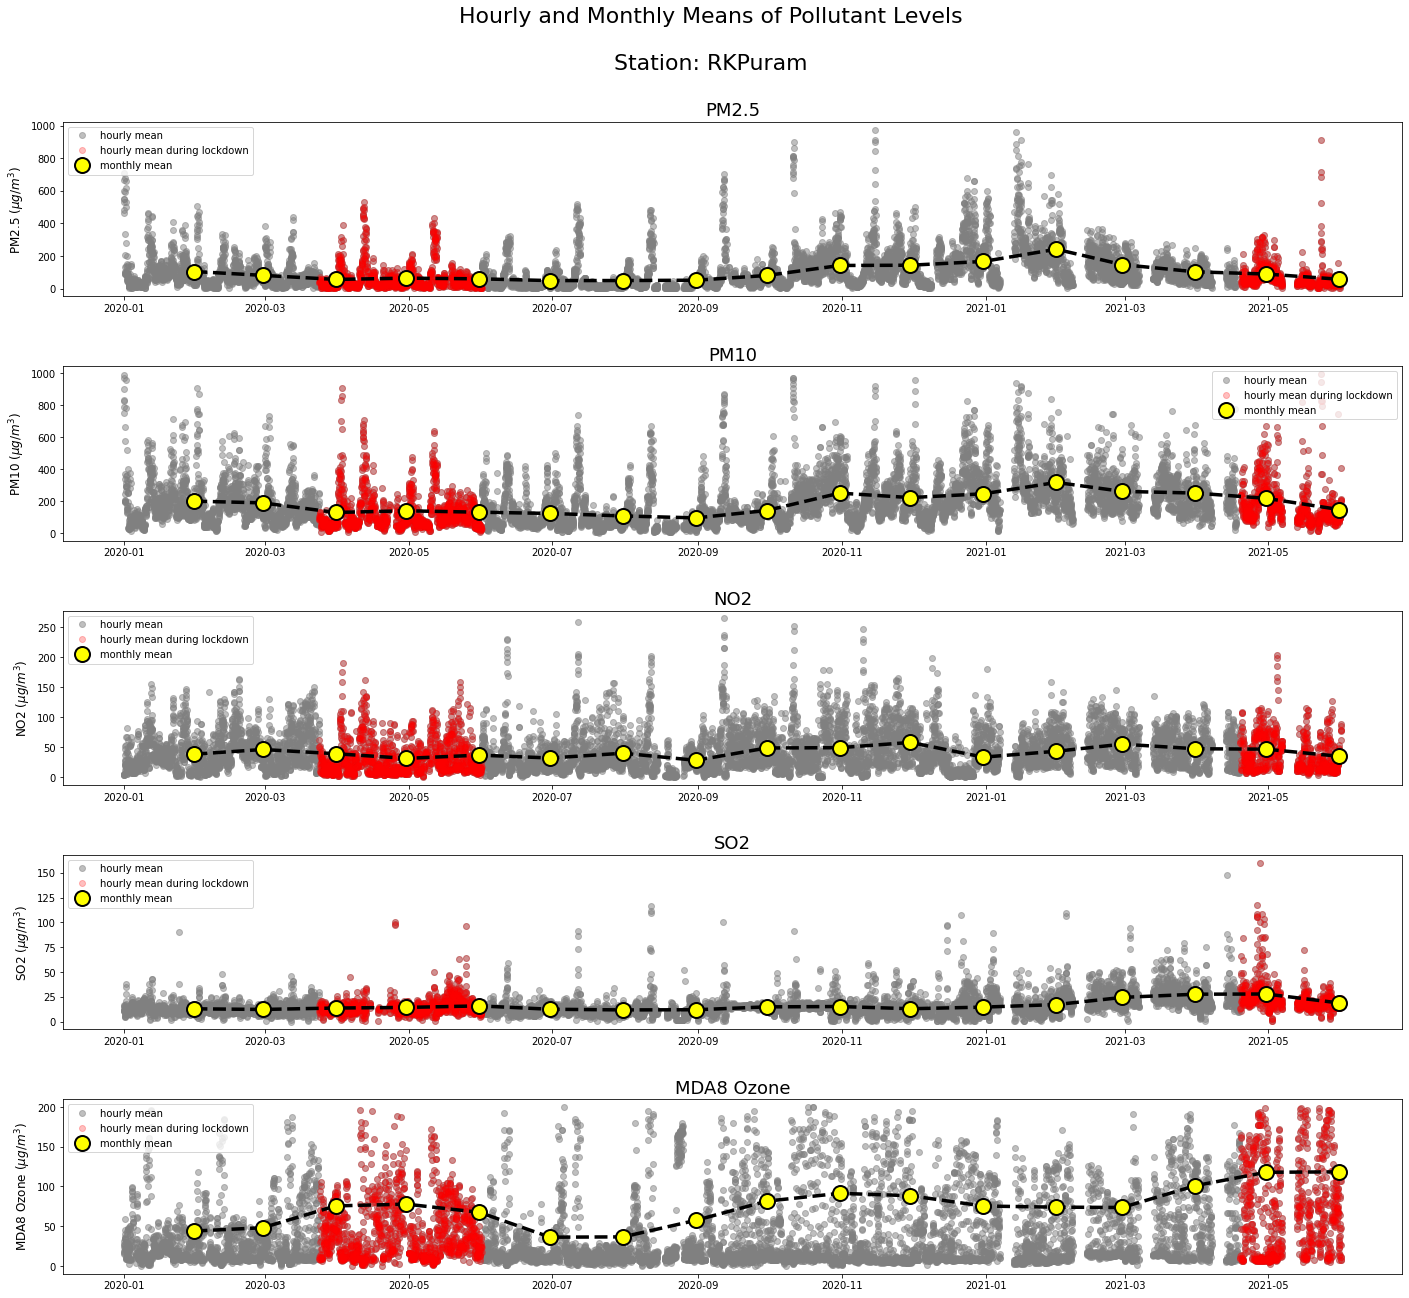

In [319]:
plotStationData('RKPuram')

# Compare average values surrounding lockdown periods, by station

In [34]:
def graphPeriods(station):
    graph_data = pd.DataFrame(index=['PRELD2020', 'LD2020', 'POSTLD2020', 'PRELD2021', 'LD2021'],
                              columns=station_data[station]['original'].columns)

    def add_data(df_station, datestr1, datestr2, rowstr):
        subset = df_station.loc[datestr1:datestr2]
        for col in subset:
            species = subset[col]
            elems = []
            for elem in species:
                if not math.isnan(elem):
                    elems.append(elem)
            if len(elems) > 0:
                avg = sum(elems) / len(elems)
                graph_data.loc[rowstr, col] = avg
            else:
                graph_data.loc[rowstr, col] = math.nan

    add_data(station_data[station]['daily'], '2020-03-01', '2020-03-23', 'PRELD2020')
    add_data(station_data[station]['daily'], '2020-03-24', '2020-05-31', 'LD2020')
    add_data(station_data[station]['daily'], '2020-06-01', '2020-06-30', 'POSTLD2020')
    add_data(station_data[station]['daily'], '2021-03-24', '2021-04-18', 'PRELD2021')
    add_data(station_data[station]['daily'], '2021-04-19', '2021-05-31', 'LD2021')

    print(station)
    print(graph_data)
    print()
    print('Pre-Lockdown 2020: March 1-March 23')
    print('Lockdown 2020: March 24-May 31')
    print('Post-Lockdown 2020: June 1-June 30')
    print('Pre-Lockdown 2021: March 24-April 18')
    print('Pre-Lockdown 2021: April 19-May 31')
    
    cols = graph_data.columns
    fig, axs = plt.subplots(len(cols), figsize=(10,23))
    colors = ['y', 'y', 'y', 'b', 'b']
    
    for col, ax, c in zip(cols, axs, colors):
        y1 = graph_data[col]['PRELD2020':'POSTLD2020'] 
        ax.bar(x=graph_data.index[0:3], height=y1, color='y')
        y2 = graph_data[col]['PRELD2021':] 
        ax.bar(x=graph_data.index[3:], height=y2, color='b')
        ax.set_ylabel(col + ' ($µg/m^3$)', fontsize=10)
        ax.set_title(col, fontsize=14)
    
    plt.suptitle('Comparing Pollutant Levels Before,\nDuring, and After Lockdown\n\n' +
              'Station: ' + station, fontsize='18')
    plt.subplots_adjust(bottom=0.1, 
                        top=0.9, 
                        hspace=0.4)
    
    fig_title = 'Lockdown_Comparison_' + station + '.tiff'
    plt.savefig(fig_title, bbox_inches="tight")
    plt.show()
    
    return graph_data

RKPuram
                 PM25        PM10        NO2        SO2       Ozone
PRELD2020   65.768631  150.587396  47.643496   14.09089   76.593756
LD2020      57.987096   125.86166   31.86047   14.83013   72.562999
POSTLD2020  48.996723  122.275633  31.987365  12.470394   36.194358
PRELD2021   80.182354  203.996086  44.654449  24.505174  107.258681
LD2021      69.266647  174.043977  37.623547  23.195485   128.14398

Pre-Lockdown 2020: March 1-March 23
Lockdown 2020: March 24-May 31
Post-Lockdown 2020: June 1-June 30
Pre-Lockdown 2021: March 24-April 18
Pre-Lockdown 2021: April 19-May 31


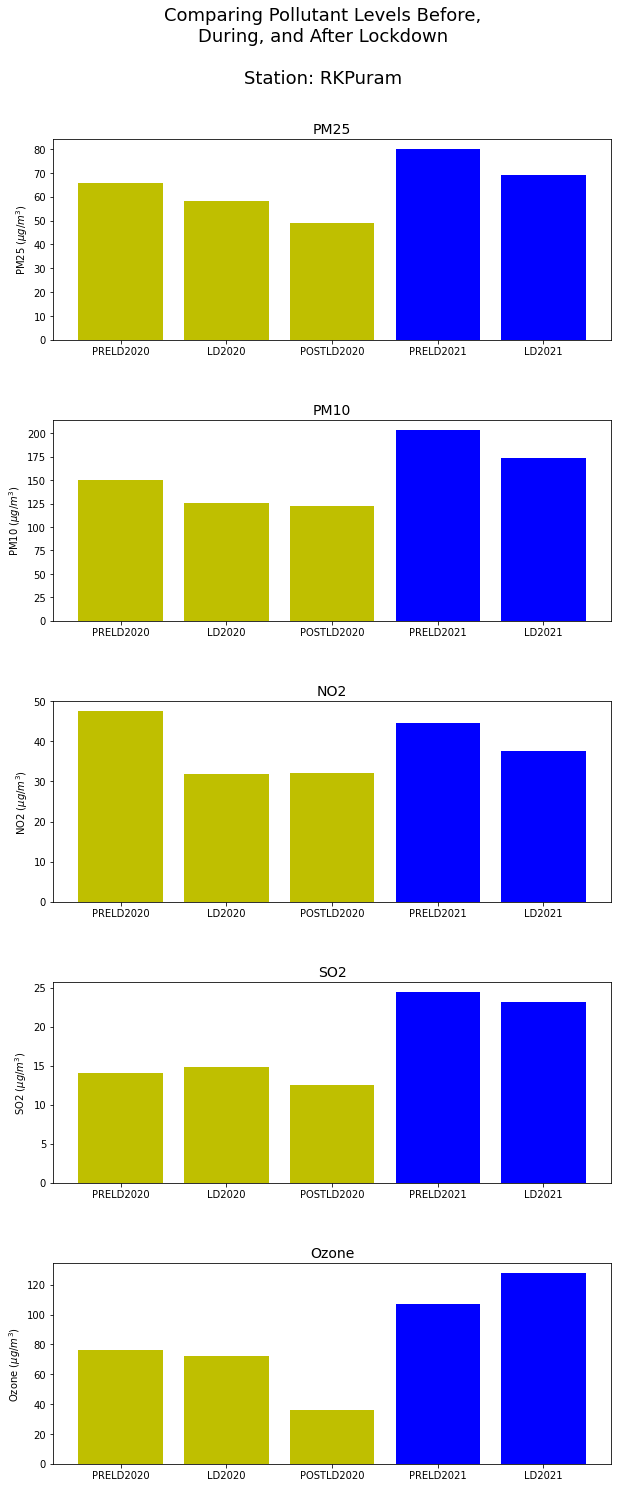

In [35]:
graphdat_RKPuram = graphPeriods('RKPuram')

# Holistic approach (average species levels across all stations)

In [36]:
# AVERAGE VALUES ACROSS ALL STATIONS FOR EACH SPECIES
# STORE DATAFRAMES IN DICTIONARY 'holistic'

holistic = {}
time_levels = ['hourly', 'daily', 'monthly', 'seasonal', 'yearly']

for time_level in time_levels:
    # use arbitrary station to get the list of datetime indices
    ts_index = station_data['Alipur'][time_level].index

    # initialize df's for summarizing species data across stations
    pm25 = pd.DataFrame(index=ts_index)
    pm10 = pd.DataFrame(index=ts_index)
    no2 = pd.DataFrame(index=ts_index)
    so2 = pd.DataFrame(index=ts_index)
    ozone = pd.DataFrame(index=ts_index)

    for station in station_data:
        df = station_data[station][time_level]
        cols = df.columns
        if 'PM25' in cols:
            pm25[station] = df['PM25']
        if 'PM10' in cols:
            pm10[station] = df['PM10']
        if 'NO2' in cols:
            no2[station] = df['NO2']
        if 'SO2' in cols:
            so2[station] = df['SO2']
        if 'Ozone' in cols:
            ozone[station] = df['Ozone']

    holistic[time_level] = {}
    holistic[time_level]['PM25'] = pm25.mean(axis=1, skipna=True)
    holistic[time_level]['PM10'] = pm10.mean(axis=1, skipna=True)
    holistic[time_level]['NO2'] = no2.mean(axis=1, skipna=True)
    holistic[time_level]['SO2'] = so2.mean(axis=1, skipna=True)
    holistic[time_level]['Ozone'] = ozone.mean(axis=1, skipna=True)

In [37]:
holistic['hourly']['PM25'].loc[:'2021-05-31']

From Date
2020-01-01 00:00:00    615.158786
2020-01-01 01:00:00    556.425929
2020-01-01 02:00:00    500.178500
2020-01-01 03:00:00    453.932059
2020-01-01 04:00:00    440.893358
                          ...    
2021-05-31 19:00:00     48.268763
2021-05-31 20:00:00     55.567652
2021-05-31 21:00:00     62.216338
2021-05-31 22:00:00     65.829040
2021-05-31 23:00:00     69.277879
Freq: H, Length: 12408, dtype: float64

In [38]:
# averages of species levels from March 22, 2020 - March 31, 2020
species_ld = [holistic['daily']['PM25'].loc['2020-03-22':'2020-03-31'].mean(),
              holistic['daily']['PM10'].loc['2020-03-22':'2020-03-31'].mean(),
              holistic['daily']['NO2'].loc['2020-03-22':'2020-03-31'].mean(),
              holistic['daily']['SO2'].loc['2020-03-22':'2020-03-31'].mean(),
              holistic['daily']['Ozone'].loc['2020-03-22':'2020-03-31'].mean()]

# March 2020 averages for each species
march_avgs = [holistic['monthly']['PM25'].loc['2020-03-31'],
              holistic['monthly']['PM10'].loc['2020-03-31'],
              holistic['monthly']['NO2'].loc['2020-03-31'],
              holistic['monthly']['SO2'].loc['2020-03-31'],
              holistic['monthly']['Ozone'].loc['2020-03-31']]

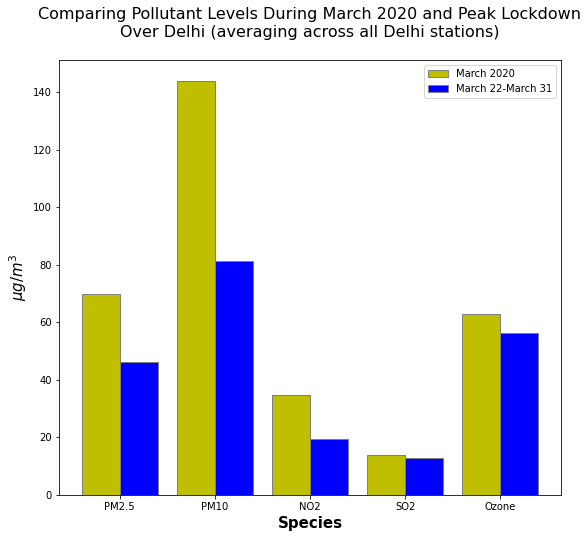

In [39]:
barWidth = 0.4
fig = plt.subplots(figsize =(9, 8))
 
# set position of bar on x-axis
br1 = np.arange(len(species_ld))
br2 = [x + barWidth for x in br1]
 
# make the plot
plt.bar(br1, march_avgs, color ='y', width = barWidth,
        edgecolor ='grey', label ='March 2020')
plt.bar(br2, species_ld, color ='b', width = barWidth,
        edgecolor ='grey', label ='March 22-March 31')

plt.xlabel('Species', fontweight ='bold', fontsize = 15)
plt.ylabel('$µg/m^3$', fontweight ='bold', fontsize = 15)
plt.xticks([r + (0.5*barWidth) for r in range(len(march_avgs))],
           ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone'])
plt.title('Comparing Pollutant Levels During March 2020 and Peak Lockdown\n' +
          'Over Delhi (averaging across all Delhi stations)\n', fontsize=16) 
plt.legend()
fig_title = 'Holistic_Lockdown_Comparison.tiff'
plt.savefig(fig_title, bbox_inches="tight")
plt.show()

# Plot holistic hourly and monthly means by species
## Averaged across all Delhi stations

In [40]:
def plotSpecies(pollutant):
    
    accepted = ['PM2.5', 'PM10', 'NO2', 'SO2', 'Ozone']
    if pollutant not in accepted:
        print('Pollutant not valid. Options: PM2.5, PM10, NO2, SO2, and Ozone.')
        return
    
    if pollutant == 'PM2.5':
        pollutant = 'PM25'
        
    fig, ax = plt.subplots(figsize=(12,7))
          
    y1 = holistic['hourly'][pollutant].loc[:'2021-05-31'] # df with hourly mean values
    ld1 = y1.loc['2020-03-24':'2020-05-31']
    ld2 = y1.loc['2021-04-19':'2021-05-31']
    y2 = holistic['monthly'][pollutant].loc[:'2021-05-31'] # df with monthly means

    # Plotting hourly mean values in the backdrop
    ax.plot(y1, linestyle='', marker='o', color='grey', mec='grey', alpha=0.5, linewidth='2.5', \
            label='hourly mean')
    ax.plot(ld1, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5', \
            label='hourly mean during lockdown')
    ax.plot(ld2, linestyle='', marker='o', color='red', mec='red', alpha=0.25, linewidth='2.5',)

    # Overlaying hourly mean values with monthly means
    ax.plot(y2, linestyle='--', color = 'black', linewidth='3.5') # monthly means as dotted lines
    ax.plot(y2, marker='o', markersize=15, linewidth=0,
         markerfacecolor='yellow',
         markeredgecolor='black',
         markeredgewidth=2, label='monthly mean') # monthly means as yellow dot

    if pollutant == 'PM25':
        pollutant = 'PM2.5'
    elif pollutant == 'Ozone':
        pollutant = 'MDA8 Ozone'
        
    ax.set_ylabel(pollutant + ' ($µg/m^3$)', fontsize=12)
    ax.set_title(pollutant + ' Over Delhi (averaged across all Delhi stations)', fontsize=18)
    
    plt.legend()
    
    fig_title = 'Timeseries_' + pollutant + '.tiff'
    plt.savefig(fig_title, bbox_inches="tight")    

    print('figure ready:', fig_title)
    plt.show()    

figure ready: Timeseries_PM2.5.tiff


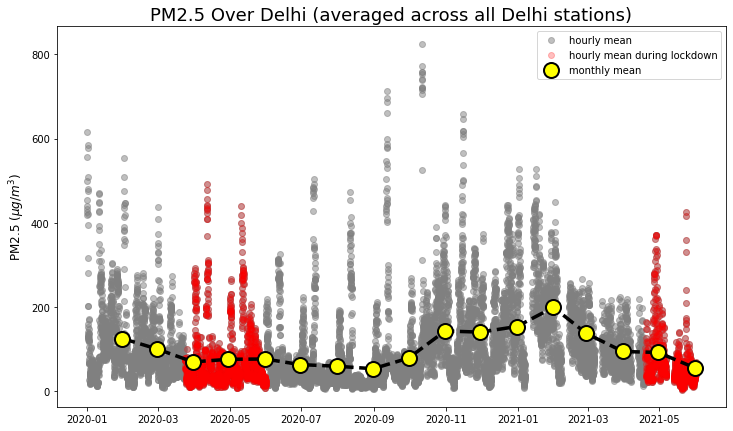

In [41]:
plotSpecies('PM2.5')

figure ready: Timeseries_PM10.tiff


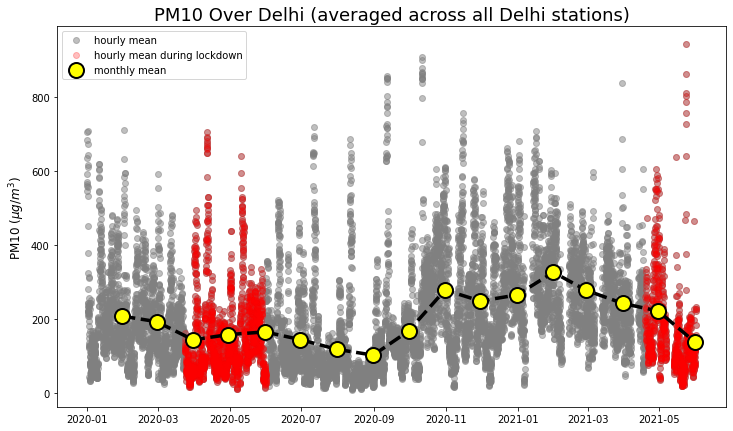

In [42]:
plotSpecies('PM10')

figure ready: Timeseries_NO2.tiff


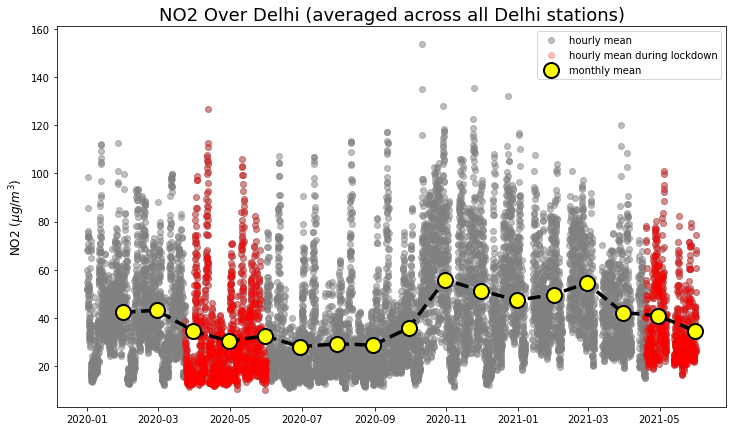

In [43]:
plotSpecies('NO2')

figure ready: Timeseries_SO2.tiff


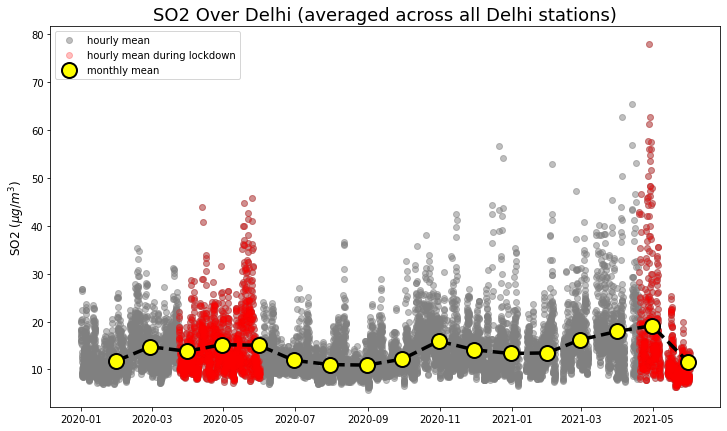

In [44]:
plotSpecies('SO2')

figure ready: Timeseries_MDA8 Ozone.tiff


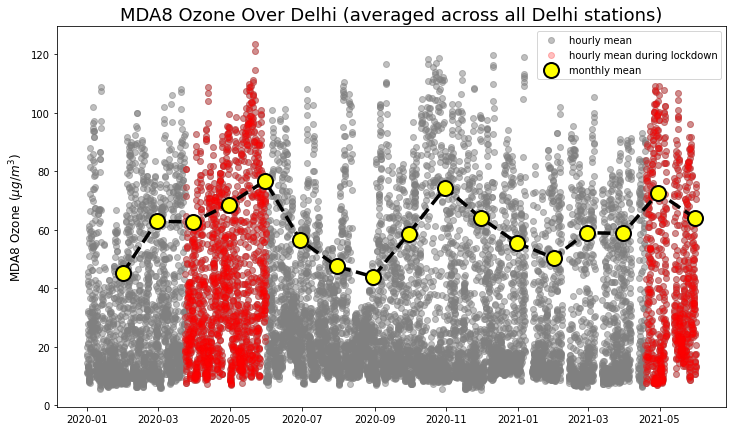

In [45]:
plotSpecies('Ozone')